In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [2]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [4]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file= 'Bd2JpsiKS_sanity.root'
mc_dir = os.path.join(mc_dir, mc_file)
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
data_file= 'Bd2JpsiKS_sanity.root'
data_dir = os.path.join(data_dir, data_file)

In [5]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_data = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
tree_mc = 'Bd2JpsiKS'

Names of variables used in this selection
-------------------------------------------------------

In [6]:
variables = [
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',
'B0_FitDaughtersConst_M_flat',
'B0_FitDaughtersConst_chi2_flat',
'B0_FitDaughtersConst_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_IP_flat',   
'B0_FitDaughtersConst_KS0_P1_PT_flat',
'B0_FitDaughtersConst_KS0_P0_PT_flat',  
'B0_FitDaughtersConst_KS0_decayLength_flat',
'B0_FitDaughtersConst_KS0_IP_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status_flat',
'B0_FitDaughtersConst_KS0_P1_PT_flat', 
'B0_FitDaughtersConst_KS0_P0_PT_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
'B0_FitPVConst_KS0_tau_flat',
'B0_FitPVConst_KS0_tauErr_flat',
#'B0_FitPVConst_IPCHI2',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_MinIPCHI2anyPV_flat',
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_status_flat',
'B0_FitPVConst_status_flat',
'piplus_TRACK_Type',
'piminus_MINIPCHI2',
'piplus_MINIPCHI2',
'muminus_MINIPCHI2',
'muplus_MINIPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'runNumber',
'idxRandom',
'idxEventNumber',
'idxRunNumber'
#'B0_FitwithoutConst_chi2',
#'B0_FitwithoutConst_nDOF',
#'B0_FitPVConst_chi2_flat',
#'B0_FitPVConst_nDOF_flat'

]

variables_mc = [
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',
'B0_FitDaughtersConst_M_flat',
'B0_FitDaughtersConst_chi2_flat',
'B0_FitDaughtersConst_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_IP_flat',   
'B0_FitDaughtersConst_KS0_P1_PT_flat',
'B0_FitDaughtersConst_KS0_P0_PT_flat',  
'B0_FitDaughtersConst_KS0_decayLength_flat',
'B0_FitDaughtersConst_KS0_IP_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
'B0_M',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status_flat',
'B0_FitDaughtersConst_KS0_P1_PT_flat', 
'B0_FitDaughtersConst_KS0_P0_PT_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
'B0_FitPVConst_KS0_tau_flat',
'B0_FitPVConst_KS0_tauErr_flat',
'B0_BKGCAT',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_MinIPCHI2anyPV_flat',
'B0_TAU',
'B0_TAUERR',
'B0_TRUETAU',
'B0_FitDaughtersConst_status_flat',
'B0_FitPVConst_status_flat',
'pv_z_pull',
'piplus_TRACK_Type',
'piminus_MINIPCHI2',
'piplus_MINIPCHI2',
'muminus_MINIPCHI2',
'muplus_MINIPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'runNumber',
#'B0_FitwithoutConst_chi2',
#'B0_FitwithoutConst_nDOF',
'B0_FitPVConst_chi2_flat',
'B0_FitPVConst_nDOF_flat',
'idxRandom',
'idxEventNumber',
'idxRunNumber',
'B0_FitPVConst_tauErr_flat',
'B0_FitPVConst_tau_flat'
]

In [7]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [8]:
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data, columns=variables,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

Generate new features
------------------------------------

In [9]:
#add symmetrical variables to dataframe
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(real_dataframe_wrongPV, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT_flat', 'B0_FitDaughtersConst_KS0_P0_PT_flat'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT_flat', 'B0_FitDaughtersConst_KS0_P0_PT_flat'])
#choose minimal value of both pions ipchi2
add_min_to_dataframe(real_dataframe_wrongPV, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat'])
#choose minimal value of both myons transversal momentum
add_min_to_dataframe(real_dataframe_wrongPV, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat'])
add_min_to_dataframe(signal_dataframe_wrongPV, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat'])
#Generate dimensionless decay-time distribution
real_dataframe_wrongPV['B0_FitPVConst_KS0_tau_dimless'] = real_dataframe_wrongPV['B0_FitPVConst_KS0_tau_flat']/real_dataframe_wrongPV['B0_FitPVConst_KS0_tauErr_flat']
signal_dataframe_wrongPV['B0_FitPVConst_KS0_tau_dimless'] = signal_dataframe_wrongPV['B0_FitPVConst_KS0_tau_flat']/signal_dataframe_wrongPV['B0_FitPVConst_KS0_tauErr_flat']

In [10]:
real_dataframe = real_dataframe_wrongPV.query('idxPV==0')
signal_dataframe = signal_dataframe_wrongPV.query('idxPV==0')

In [11]:
#del signal_dataframe['B0_BKGCAT']
#del signal_dataframe['__array_index']
#Just a check
signal_dataframe.shape, real_dataframe.shape 

((565006, 50), (1686472, 42))

# Calculate resolution for later use

In [38]:
signal_dataframe_wrongPV['Delta_TAU'] = signal_dataframe_wrongPV['B0_FitPVConst_tau_flat']-signal_dataframe_wrongPV['B0_TRUETAU']

Compare MC signal with Data sideband
------------------------------------------------

In [12]:
#Apply masscut for sideband
cutstring = 'B0_FitDaughtersConst_M_flat>5450&idxPV==0'
#data_dir_bkg = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_data.root'

In [13]:
variables_bkg = [
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',
'B0_FitDaughtersConst_M_flat',
'B0_FitDaughtersConst_chi2_flat',
'B0_FitDaughtersConst_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_IP_flat',   
'B0_FitDaughtersConst_KS0_P1_PT_flat',
'B0_FitDaughtersConst_KS0_P0_PT_flat',  
'B0_FitDaughtersConst_KS0_decayLength_flat',
'B0_FitDaughtersConst_KS0_IP_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status_flat',
'B0_FitDaughtersConst_KS0_P1_PT_flat', 
'B0_FitDaughtersConst_KS0_P0_PT_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
'B0_FitPVConst_KS0_tau_flat',
'B0_FitPVConst_KS0_tauErr_flat',
#'B0_FitPVConst_IPCHI2',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_MinIPCHI2anyPV_flat',
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_status_flat',
'B0_FitPVConst_status_flat',
'piplus_TRACK_Type',
'piminus_MINIPCHI2',
'piplus_MINIPCHI2',
'muminus_MINIPCHI2',
'muplus_MINIPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'runNumber'
]

In [14]:
bkg_dataframe = rp.read_root(data_dir,key=tree_data, columns=variables_bkg,where=cutstring, flatten=False)
bkg_dataframe = bkg_dataframe.replace([np.inf, -np.inf], np.nan)
bkg_dataframe = bkg_dataframe.dropna()

In [15]:
#bkg_dataframe = pd.concat([bkg_dataframe_2015,bkg_dataframe_2016])

In [16]:
#del bkg_dataframe['__array_index']

In [17]:
#add symmetrical variables to dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT_flat', 'B0_FitDaughtersConst_KS0_P0_PT_flat'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(bkg_dataframe, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(bkg_dataframe, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat'])

#Generate bkg_dataframedimensionless decay-time distribution
bkg_dataframe['B0_FitPVConst_KS0_tau_dimless'] = bkg_dataframe['B0_FitPVConst_KS0_tau_flat']/bkg_dataframe['B0_FitPVConst_KS0_tauErr_flat']

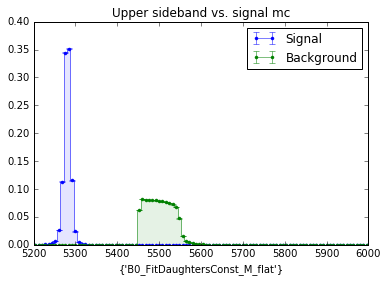

In [18]:
dataframe_names = ['Signal', 'Background']
plot_vars = ['B0_FitDaughtersConst_M_flat']
plot_names = ['Upper sideband vs. signal mc']
dataframe_list = [signal_dataframe, bkg_dataframe]
plotter = Plotter()
plotter.create_plots(dataframe_list, plot_vars, None, plot_names , dataframe_names)
plotter['Upper sideband vs. signal mc'].set_range(5200, 6000)
p = Plotter('/home/chasenberg/plots/selection/')
plotter.plot()

Declare bdt features and correlation matrix and monte-carlo agreement
---------------------------------------------------------------------------------

In [19]:
bdt_features = [
'B0_FitDaughtersConst_chi2_flat',
'B0_FitDaughtersConst_IPCHI2_flat',
#'B0_FitDaughtersConst_J_psi_1S_IP',   
#'B0_FitDaughtersConst_KS0_P1_PT',
#'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_min_PT',
'B0_FitDaughtersConst_KS0_decayLength_flat',
'B0_FitPVConst_KS0_tau_dimless',
#'test_IP',
'B0_FitDaughtersConst_KS0_IP_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
#'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

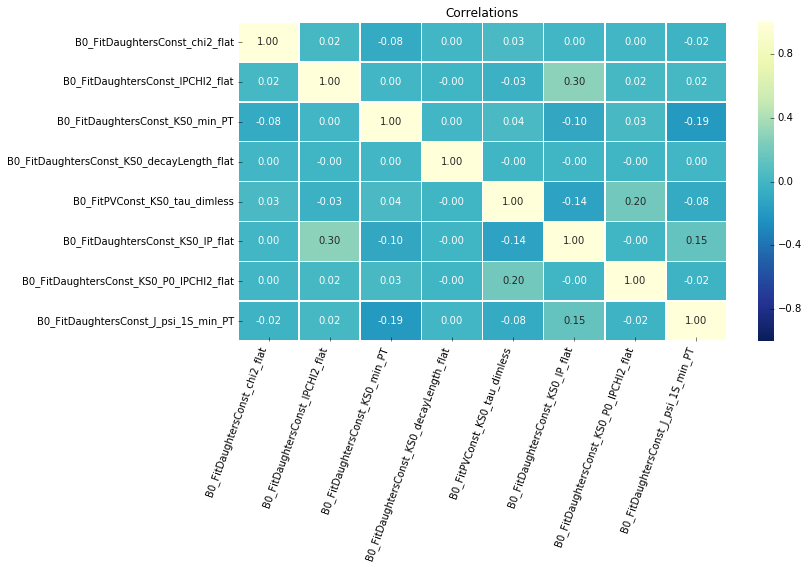

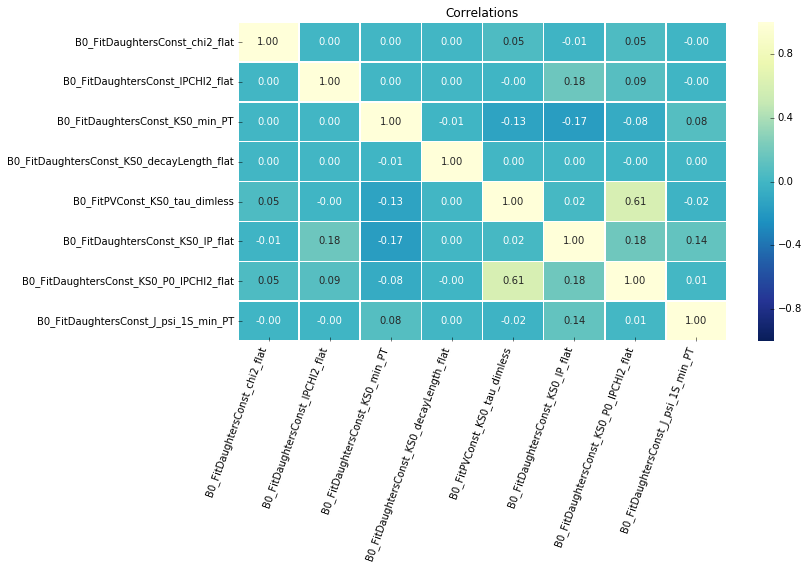

Done!


In [20]:
plt.figure(figsize=(12,8))
plot_correlations(bkg_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/selection/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/selection/correlation_mc.png')
plt.show()
print('Done!')

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [21]:
'''#Check bdt-variables in downstream events
mc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())
signal_dataframe['mc_weight'] = mc_weight
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/bdt_check/')
    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.99))
    #plotter[feature].set_range(0,20)
    plotter.plot()'''

"#Check bdt-variables in downstream events\nmc_weight = np.ones(signal_dataframe['B0_FitDaughtersConst_M'].count())\nsignal_dataframe['mc_weight'] = mc_weight\nfor feature in bdt_features:\n    plotter = Plotter('/home/chasenberg/plots/bdt_check/')\n    plotter.create_plots([real_dataframe,signal_dataframe], feature, weightvars=['SigYield_sw','mc_weight']\n    ,component_labels=['sWeighted data','Signal-MC'])\n    plotter[feature].set_range(0,real_dataframe[feature].quantile(0.99))\n    #plotter[feature].set_range(0,20)\n    plotter.plot()"

Train GradienBoost classifier
====================================================================

In [22]:
flags = np.array([1]*len(signal_dataframe)+[0]*len(bkg_dataframe))
dataframe = pd.concat([signal_dataframe, bkg_dataframe])

In [23]:
signal_dataframe.shape, bkg_dataframe.shape,dataframe.shape

((565006, 50), (525694, 39), (1090700, 50))

In [24]:
#Apply Track Type cuts piminus_TRACK_Type

In [25]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=4, verbose=1,n_estimators=200,learning_rate=0.05)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           1.3140            5.14m
         2           1.2497            4.97m
         3           1.1914            4.75m
         4           1.1381            4.51m
         5           1.0891            4.30m
         6           1.0443            4.16m
         7           1.0029            4.05m
         8           0.9649            3.97m
         9           0.9295            3.97m
        10           0.8967            3.98m
        20           0.6707            3.88m
        30           0.5515            3.68m
        40           0.4845            3.42m
        50           0.4431            3.25m
        60           0.4162            3.05m
        70           0.3976            2.82m
        80           0.3843            2.59m
        90           0.3744            2.43m
       100           0.3670            2.23m
       200           0.3374            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [26]:
dataframe.shape

(1090700, 50)

Classifier performance
-----------------------

In [27]:
classifier.score(test_dataframe, test_flags)

0.93394700650958096

In [28]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_FitDaughtersConst_IPCHI2_flat: 0.3156
B0_BKGCAT: 0.1347
B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat: 0.1282
B0_FitDaughtersConst_J_psi_1S_P1_PT_flat: 0.1077
B0_FitDaughtersConst_J_psi_1S_IP_flat: 0.0859
B0_FitDaughtersConst_KS0_IP_flat: 0.0832
B0_FitDaughtersConst_J_psi_1S_min_PT: 0.0731
B0_FitDaughtersConst_J_psi_1S_P0_PT_flat: 0.0716


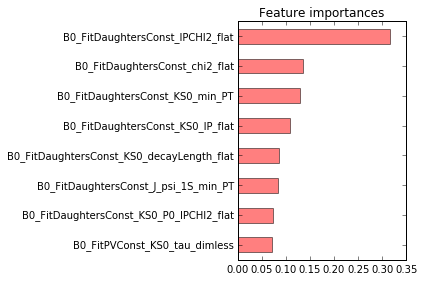

In [29]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/selection/feature_importance.png', bbox_inches='tight')

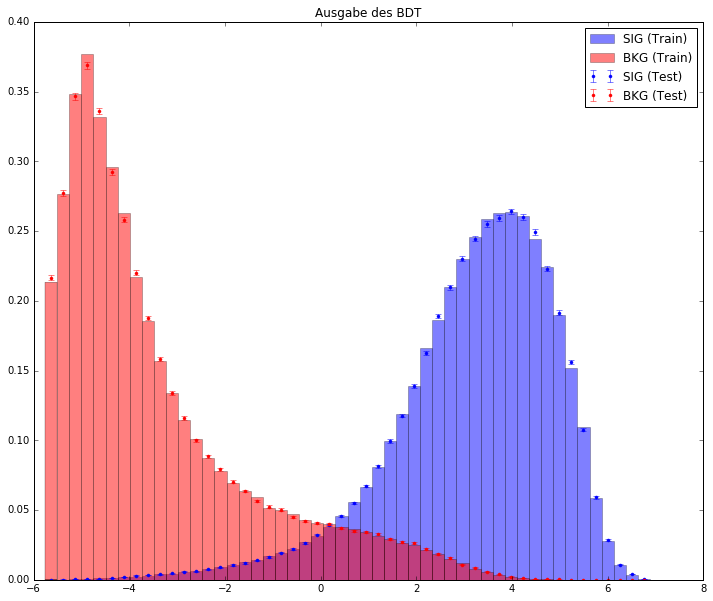

In [30]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/selection/overtraining.png')
plt.show()


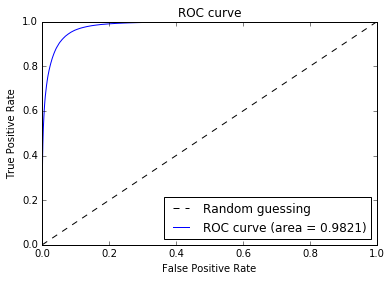

In [31]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/selection/roc_curve.png')




Classify unseen Data
============================================

In [32]:
variables_unseen = [
'B0_TAGDECISION_OS',
'B0_TAGOMEGA_OS',
'B0_FitDaughtersConst_M_flat',
'B0_FitDaughtersConst_chi2_flat',
'B0_FitDaughtersConst_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_IP_flat',   
'B0_FitDaughtersConst_KS0_P1_PT_flat',
'B0_FitDaughtersConst_KS0_P0_PT_flat',  
'B0_FitDaughtersConst_KS0_decayLength_flat',
'B0_FitDaughtersConst_KS0_IP_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
'idxPV',
'piplus_TRACK_Type',
'B0_FitPVConst_status_flat',
'B0_FitDaughtersConst_KS0_P1_PT_flat', 
'B0_FitDaughtersConst_KS0_P0_PT_flat',
'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
'B0_FitPVConst_KS0_tau_flat',
'B0_FitPVConst_KS0_tauErr_flat',
#'B0_FitPVConst_IPCHI2',
'B0_FitPVConst_IPCHI2_flat',
'B0_FitPVConst_MinIPCHI2anyPV_flat',
'B0_TAU',
'B0_TAUERR',
'B0_FitDaughtersConst_status_flat',
'B0_FitPVConst_status_flat',
'piplus_TRACK_Type',
'piminus_MINIPCHI2',
'piplus_MINIPCHI2',
'muminus_MINIPCHI2',
'muplus_MINIPCHI2',
'piplus_ProbNNp',
'piminus_ProbNNp',
'varLambda0MassHypo_ppluspiminus',
'varLambda0MassHypo_pminuspiplus',
'eventNumber',
'runNumber',
'idxRandom',
'idxEventNumber',
'idxRunNumber',
'B0_FitPVConst_tauErr_flat',
'B0_FitPVConst_tau_flat'
]

unseen_dir = data_dir  
unseen_df = rp.read_root(unseen_dir,key=tree_data, columns=variables_unseen,where=cut_string_data, flatten=False)
unseen_df = unseen_df.replace([np.inf, -np.inf], np.nan)
unseen_df = unseen_df.dropna()

In [33]:
#add symmetrical variables to dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(unseen_df, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT_flat', 'B0_FitDaughtersConst_KS0_P0_PT_flat'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(unseen_df, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2_flat', 'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(unseen_df, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT_flat', 'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat'])

#Generate bkg_dataframedimensionless decay-time distribution
unseen_df['B0_FitPVConst_KS0_tau_dimless'] = unseen_df['B0_FitPVConst_KS0_tau_flat']/unseen_df['B0_FitPVConst_KS0_tauErr_flat']

In [39]:
#apply classifier to data and MC
classify_unseen_data([classifier], unseen_df, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], signal_dataframe_wrongPV, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], signal_dataframe, bdt_features, 'BDTresponse')
classify_unseen_data([classifier], bkg_dataframe, bdt_features, 'BDTresponse')

/home/chasenberg/repos/dopy/dolearn/sklearn_utils.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[decision_column] = decision_vector


Write dataframe with BDT output to ROOT file
-------------------------------

In [35]:
efficiency = signal_dataframe.query('BDTresponse>0.48').shape[0] / signal_dataframe.shape[0]
print(efficiency)

0.9316325844327317


In [40]:
signal_dataframe_wrongPV.query('BDTresponse>1.15').to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_selected.root',key='Bd2JpsiKS')

Calculate simple FOM
---------------------------

In [ ]:
bdt_cuts = np.linspace(-6,6,60)
fom_arr = []
for cut in bdt_cuts:
    nevents_after_bdt_dbkg = len(bkg_dataframe[bkg_dataframe['BDTresponse']>cut])
    nevents_after_bdt_signal = len(signal_dataframe[signal_dataframe['BDTresponse']>cut])
    fom = nevents_after_bdt_signal  / np.sqrt(nevents_after_bdt_dbkg+nevents_after_bdt_signal)
    fom_arr.append(fom)

In [ ]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(bdt_cuts, fom_arr,k=4, s=0)
spl.set_smoothing_factor(0.5)
plt.plot(bdt_cuts, fom_arr, 'ro', ms=5)
plt.plot(bdt_cuts,spl(bdt_cuts),'b')
plt.xlabel("BDT-Cut")
plt.ylabel("FOM")
plt.savefig('/home/chasenberg/plots/selection/effective_signalsize.png')

In [ ]:
#Maximum of FOM
bdt_cut = spl.derivative().roots()[0]

In [ ]:
#Plot realdata with bdt cuts 
test =  unseen_df[unseen_df['BDTresponse']>0.5]
p = Plotter('/home/chasenberg/plots/selection/')
p.create_plots([unseen_df,test],'B0_FitDaughtersConst_M_flat',component_labels=['Data','Data_BDTCut'])
p['B0_FitDaughtersConst_M_flat'].set_range(5220, 5400)
#bdt_plot.plot()
p.plot()
efficiency = len(test) / len(real_dataframe)
n_sig = unseen_df[unseen_df['BDTresponse']>bdt_cut].shape[0]
print("Efficiency of the cut:",efficiency)
print("Number of Signalevents:",n_sig)

Compare data without triggerline requirements against selected data
-----------------------------------------------------------

In [ ]:
unseen_df.query('BDTresponse>0.31').shape

In [ ]:
#Write test-dataframe to root file 
unseen_df.query('BDTresponse>1.15').to_root('/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_selected.root',key='Bd2JpsiKS')
#unseen_df.to_root('/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/Bd2JpsiKS_BDTresponse.root',key='Bd2JpsiKS')

Check efficiencies for bdt cut
=========================================

In [ ]:
nevents_before_bdt = len(signal_dataframe)
print('ne£vents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(signal_dataframe.query('BDTresponse>1.15'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT signal efficiency: ' + str(nevents_after_bdt/nevents_before_bdt))

##### nevents_before_bdt = len(bkg_dataframe)
print('nevents before BDT cut: ' + str(nevents_before_bdt))
nevents_after_bdt = len(bkg_dataframe.query('BDTresponse>0.67'))
print('nevents after BDT cut: ' + str(nevents_after_bdt))
print('BDT background rejection: ' + str(1-nevents_after_bdt/nevents_before_bdt))